### Basic imports

In [1]:
%load_ext autoreload

###### Important note!
If you started from docker containing the graph-tool package, you probably need to specify the path for the other python packages you have (I didn't manage to install packages inside the docker container...). Note that this might mess with importing packages in other anaconda environments (it did for me), but that is a problem for another day ;)

In [ ]:
import sys
sys.path.append('/home/tandemelephant/anaconda3/envs/graph-tool/lib/python3.7/site-packages')

In [2]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

from copy import deepcopy
from tqdm import tqdm_notebook as tqdm

In [3]:
pd.set_option('display.max_colwidth', 100)

### Definitions

#### Get size of variables in memory

In [4]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def get_size_of_vars(n=10):
    size_of_rest = 0
    i = 0
    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                             key= lambda x: -x[1]):
        if i < n:
            print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))
        else:
            size_of_rest += size
        i += 1

    print("{:>30}: {:>8}".format('Size of rest', sizeof_fmt(size_of_rest)))

#### Get topic mixtures, print topic examples

In [5]:
def get_hsbm_topics_dict(hsbm_model, level=0, num_words=100):
    topics = hsbm_model.topics(l=level,n=num_words)
    freq_sum = {topic : sum([freq for (word, freq) in word_freq]) 
                for (topic, word_freq) in topics.items() }
    return {topic : {word : freq/freq_sum[topic] for (word, freq) in word_freq} 
                for (topic, word_freq) in topics.items() }

def get_lda_topics_dict(lda_model, num_topics=-1, num_words=100):
    topics = lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False)
    freq_sum = {topic : sum([freq for (word, freq) in word_freq]) 
                for (topic, word_freq) in topics }
    return {topic : {word : freq/freq_sum[topic] for (word, freq) in word_freq} 
                for (topic, word_freq) in topics}

def get_topic_score(token_list, topics_dict):
    return [sum([topics_dict[topic].get(t, 0) for t in token_list]) / len(token_list)
            for topic in topics_dict]

def get_mixture_custom(doc_list, topics_dict):
    doc_scores = data.loc[doc_list].tokens.apply(get_topic_score, args=(topics_dict,))
    return pd.DataFrame(index=doc_scores.index,
                        columns=topics_dict.keys(), 
                        data=np.stack(doc_scores.values) / (np.stack(doc_scores.values).sum(axis=1).reshape(-1,1) + np.finfo(float).eps)
                       )

def get_mixture_hsbm(doc_list, hsbm_model, level=2):
    doc2id = {doc : i for (i, doc) in enumerate(hsbm_model.documents)}
    return pd.DataFrame(index=doc_list, 
                        columns=hsbm_model.topics(l=level).keys(),
                        data=[[ratio for topic, ratio in topic_dist] 
                              for topic_dist in map(lambda doc: hsbm_model.topicdist(doc2id[str(doc)], l=level), doc_list)]
                         )

def get_mixture_lda(doc_list, lda_model, bow_corpus):
    return pd.DataFrame(index=doc_list, 
                        columns=range(lda_model.get_topics().shape[0]),
                        data=[{topic:ratio for topic, ratio in topic_dist} 
                              for topic_dist in map(lambda doc: lda_model.get_document_topics(bow_corpus[doc]), doc_list)]
                         )
    
def print_topic_examples(mixture_df, n_examples=5):

    for topic in mixture_df.columns: 
        print('-'*100)
        print('-'*40 + f' TOPIC: {topic} ' + '-'*40)
        print('-'*100 + '\n\n')

        top_score_ids = mixture_df.sort_values(by=topic, ascending=False).iloc[:n_examples, topic].index
        for text in data.text[top_score_ids]:
            print(text)
            print('-'*100 + '\n')

## Read data

In [6]:
import ast

In [7]:
dir_path = '../data/tweets_maga/'
data_original = pd.read_csv(dir_path + 'data_merged.csv', index_col=0)
# convert tokens column from string to list
data_original['tokens'] = data_original.tokens.apply(lambda l: ast.literal_eval(l))
data_original

,id,text,created_at,author_name,tokens
0,1178831229963116544,@realDonaldTrump I’m confused. Is this a new “greatest” or the same as the old? All of your scan...,2019-10-01 00:37:21,RealPatriot,"[confus, new, greatest, old, scandal, hard, follow, pussygrabb]"
1,1178831224191832067,"@realDonaldTrump @Hyundai @Kia @Aptiv I'm not yet tired of winning, Sir! #MAGA",2019-10-01 00:37:20,Teresa murray⭐⭐⭐ CIA #fakewistleblower 😡,"[yet, tire, win, sir]"
2,1178831213571629057,@WA_Silenced_Maj @realDonaldTrump You are the true patriots! If Antifa physically assaults you ...,2019-10-01 00:37:17,GOPKnowsBest,"[true, patriot, antifa, physic, assault, way, legal, defend]"
3,1178831204151226368,It is amazing to watch @RudyGiuliani throw his reputation down the toilet. My guess @realDonaldT...,2019-10-01 00:37:15,Peter Dunbar,"[amaz, watch, throw, reput, toilet, guess, someth, mayb, bumbl, old, fool, hard, tell]"
4,1178831160635514880,@w_terrence @realDonaldTrump WHOOOOOHOOOOO! I’m so excited for you! #MAGA #KAG2020♥️🇺🇸,2019-10-01 00:37:04,AtlanticCity Deplorable,"[whooohooo, excit]"
5,1178831134156820480,#Trump LIED ABOUT WIKILEAKS in #MuellerReport\n\nThe grand-jury REDACTIONS in special counsel #M...,2019-10-01 00:36:58,Michael O'Grady,"[lie, wikileak, grand, juri, redact, special, counsel, report, show, presid, trump, lie, knowled..."
6,1178831070067924992,Never polled and don't know anyone that has. \n#MAGA https://t.co/n1bzaxntWX,2019-10-01 00:36:43,Lynn McCracken,"[never, poll, know, anyon]"
7,1178831062304202754,#GettumGirl\n\n#Maga needs to get off their ass and put their foot down!\n\nDems/Antifa (same th...,2019-10-01 00:36:41,U R Busted,"[need, get, ass, put, foot, dem, antifa, thing, cross, line]"
8,1178831051881418757,@realDonaldTrump Beautiful!\n#KAG\n#MAGA,2019-10-01 00:36:39,McQ,[beauti]
9,1178831004485636096,#RedOctober Did #Q mean this October? \nMaybe #JuanOSavin is onto something regarding this horri...,2019-10-01 00:36:27,SJ 🌟🌟🌟,"[mean, octob, mayb, onto, someth, regard, horribl, excus]"


In [12]:
data_original.tokens.str.len().mean()

10.285449469570073

In [56]:
# print tokens and the percentage of tweets they are in
n_tweets = len(data)
unique_tokens = np.unique(np.hstack(data.tokens.values))
counts = []
for t in tqdm(unique_tokens):
    t_count = data.tokens.apply(lambda l: t in l).sum()
    counts.append((t, t_count))
    
sorted(counts, key=lambda tup: tup[1]/n_tweets, reverse=True)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


[('1wga', 20),
 ('2012', 20),
 ('allianc', 20),
 ('alright', 20),
 ('april', 20),
 ('assassin', 20),
 ('assur', 20),
 ('athlet', 20),
 ('atkinson', 20),
 ('bigot', 20),
 ('captain', 20),
 ('cbs', 20),
 ('charad', 20),
 ('cite', 20),
 ('combat', 20),
 ('complic', 20),
 ('confront', 20),
 ('conscienc', 20),
 ('conveni', 20),
 ('demo', 20),
 ('detroit', 20),
 ('divers', 20),
 ('download', 20),
 ('driver', 20),
 ('dumber', 20),
 ('exchang', 20),
 ('export', 20),
 ('fashion', 20),
 ('fiction', 20),
 ('flow', 20),
 ('foolish', 20),
 ('founder', 20),
 ('grasp', 20),
 ('ground', 20),
 ('harvard', 20),
 ('henri', 20),
 ('hispan', 20),
 ('hug', 20),
 ('hussein', 20),
 ('instal', 20),
 ('investor', 20),
 ('jealous', 20),
 ('jerk', 20),
 ('karma', 20),
 ('kerri', 20),
 ('killari', 20),
 ('laura', 20),
 ('magat', 20),
 ('mandat', 20),
 ('math', 20),
 ('minist', 20),
 ('mobster', 20),
 ('moscow', 20),
 ('nativ', 20),
 ('nowher', 20),
 ('obey', 20),
 ('oblig', 20),
 ('ole', 20),
 ('out', 20),
 ('pal'

## Post cleaning

In [13]:
import gensim

In [14]:
data = deepcopy(data_original)

t_dict = gensim.corpora.Dictionary(data.tokens)
print('Initial unique tokens:', len(t_dict.keys()))

# drop tokens occuring in less than <no_below> tweets
# drop tokens occuring in more than <no_above> portion of the data
# keep only the <keep_n> most frequent tokens
original_tokens = set(t_dict.token2id.keys())
t_dict.filter_extremes(no_below=20, no_above=0.5, keep_n=100000)
remaining_tokens = set(t_dict.token2id.keys())
data['tokens'] = data.tokens.apply(lambda tokens: [t for t in tokens if t in remaining_tokens])

print('Remaining unique tokens:', len(remaining_tokens))

Initial unique tokens: 19259
Remaining unique tokens: 2706


In [15]:
# drop tweets with 1 or less words left
data.drop(index=data[data.tokens.str.len() <= 1].index, inplace=True)

print('Original / remaining #tweets:')
print(len(data_original), '/', len(data))

Original / remaining #tweets:
44775 / 43103


## Network based approach

### Build network

In [16]:
import networkx as nx
from networkx.algorithms.community import *
import graph_tool as gt
from sbmtm import sbmtm
import itertools

#### Naive (word-word)

In [12]:
G = nx.Graph()

for token_list in tqdm(data.tokens):
    
    for edge in itertools.combinations(token_list, 2):
        w = G.get_edge_data(*edge, default={'weight':0})['weight'] + 1
        G.add_edge(*edge, weight=w)

G = nx.convert_node_labels_to_integers(G, label_attribute='label')
print(nx.info(G))
deg_med = np.median([deg for node, deg in G.degree(weight='weight')])
print(f'Median degree: {deg_med}')

/home/tandemelephant/anaconda3/envs/graph-tool/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


ImportError: IntProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

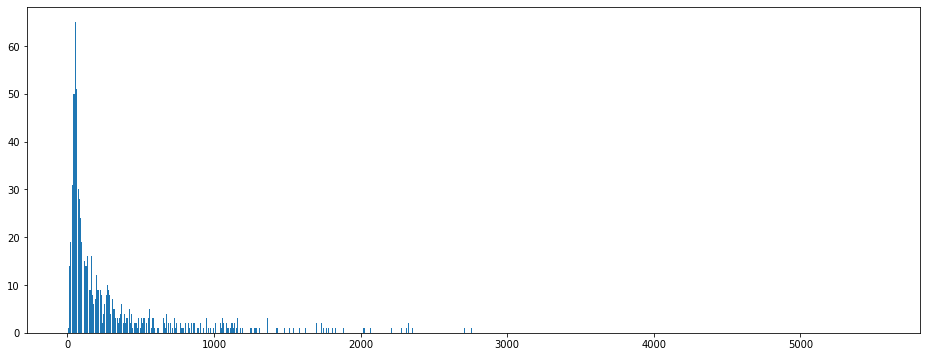

In [17]:
hist = nx.degree_histogram(G)

plt.figure(figsize=(16,6))
plt.bar(range(len(hist)), hist)

plt.show()

#### Proper (word-tweet)

In [17]:
filters = (data.tokens.str.len() >= 15)
print(f'Number of tweets: {len(data[filters])}')
print(f'Number of tokens: {data[filters].tokens.str.len().sum()}')

Number of tweets: 8906
Number of tokens: 164891


In [18]:
from sbmtm import sbmtm
import graph_tool.all as gt

texts = list(data[filters].tokens)
titles = list(data[filters].index)

## we create an instance of the sbmtm-class
hsbm_model = sbmtm()

## we have to create the word-document network from the corpus
hsbm_model.make_graph(texts,documents=titles)

## we can also skip the previous step by saving/loading a graph
hsbm_model.save_graph(filename = dir_path + 'tmp.xml.gz')
# model.load_graph(filename = dir_path + 'tmp.xml.gz')

### Find communities

#### hSBM (hierarchical Stochastic Block Model)

In [19]:
## fit the model
gt.seed_rng(42)
hsbm_model.fit()

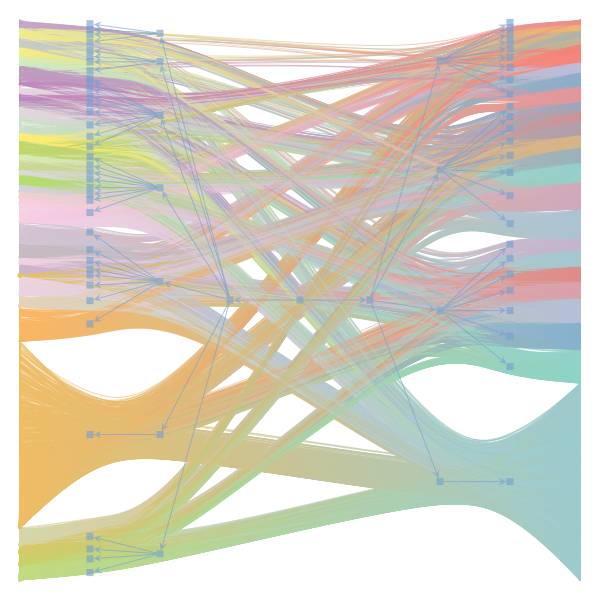

In [20]:
hsbm_model.plot(nedges=10000)
#hsbm_model.plot(nedges=10000, filename='tmp.png')

In [21]:
level=0
hsbm_model.topics(l=level, n=10)

{0: [('year', 0.0807442513603651),
  ('job', 0.048095488853782696),
  ('usa', 0.030366859750746007),
  ('fuck', 0.025451992276636828),
  ('creat', 0.020186062840091275),
  ('place', 0.019659469896436722),
  ('sell', 0.019132876952782166),
  ('problem', 0.018957345971563982),
  ('fail', 0.0175530981218185),
  ('buy', 0.015446726347200282)],
 1: [('like', 0.028714965626652565),
  ('know', 0.024748810153358013),
  ('say', 0.0245637228979376),
  ('one', 0.020544685351665787),
  ('would', 0.020068746694870437),
  ('think', 0.019196192490745636),
  ('see', 0.017239555790586992),
  ('right', 0.01554732945531465),
  ('even', 0.011369645690111053),
  ('look', 0.011343204653622423)],
 2: [('trump', 0.7733812949640287),
  ('ask', 0.07434052757793765),
  ('donald', 0.06354916067146282),
  ('gop', 0.03986810551558753),
  ('order', 0.029676258992805755),
  ('expect', 0.019184652278177457)],
 3: [('presid', 0.17219840783833434),
  ('democrat', 0.09638701775872627),
  ('take', 0.08058787507654623),
  

In [18]:
print_topic_examples(get_mixture_hsbm(data[filters].index, hsbm_model, level=level), n_examples=10)

----------------------------------------------------------------------------------------------------
---------------------------------------- TOPIC: 0 ----------------------------------------
----------------------------------------------------------------------------------------------------


Trump Trump 2016.@realDonaldTrump Trump @2020 trump  Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump Trump #MAGA
----------------------------------------------------------------------------------------------------

@CaptLowkey @mommers_j @georgina_stulen @erikmouthaanRTL #MAGA

MAGA Activist Karyn Turk Pleads Guilty to Social Security Fraud After Stealing From Her Mother

Turk stole more than $17,000 from her 83-year-old mother who suffers from dementia.  

https://t.co/zNEeYpsLXV
---------------------------------------------------------------------------

#### Greedy modularity

In [45]:
comms = list(greedy_modularity_communities(G))

In [46]:
comms

[frozenset({32768,
            1,
            3,
            32771,
            7,
            32775,
            9,
            11,
            32780,
            14,
            32782,
            16,
            'podesta',
            19,
            32787,
            32789,
            22,
            24,
            32793,
            26,
            32795,
            29,
            32797,
            32801,
            34,
            35,
            36,
            32809,
            'fill',
            32814,
            47,
            32816,
            'jeer',
            50,
            51,
            32817,
            54,
            59,
            32827,
            32828,
            62,
            32830,
            32831,
            'diaper',
            72,
            32842,
            'classi',
            'nit',
            32846,
            32848,
            'theyd',
            82,
            83,
            32850,
            86,
            32856,
 

#### Girwan-Newman

In [113]:
comms_gn = girvan_newman(G)

In [114]:
k = 5
comms_limited = itertools.takewhile(lambda c: len(c) <= k, comms_gn)
for communities in comms_limited:
    print(tuple(sorted(c) for c in communities))

KeyboardInterrupt: 

#### K-Clique

In [ ]:
k = 4
c = list(k_clique_communities(G, k))
c

## LDA (Latent Dirichlet Allocation)

In [22]:
print(f'Number of tweets: {len(data[filters])}')
print(f'Number of words: {data[filters].tokens.str.len().sum()}')

Number of tweets: 8906
Number of words: 164891


In [23]:
%autoreload
from gensim import models

bow_corpus = data[filters].tokens.apply(t_dict.doc2bow)
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [25]:
lda_models = {}

lda_models[0] = gensim.models.LdaModel(
    corpus=corpus_tfidf,
    num_topics=len(hsbm_model.topics(l=0)),
    passes=5,
    id2word=t_dict,
    alpha='auto',
)

lda_models[1] = gensim.models.LdaModel(
    corpus=corpus_tfidf,
    num_topics=len(hsbm_model.topics(l=1)),
    passes=5,
    id2word=t_dict,
    alpha='auto',
)

lda_models[2] = gensim.models.LdaModel(
    corpus=corpus_tfidf,
    num_topics=len(hsbm_model.topics(l=2)),
    passes=5,
    id2word=t_dict,
    alpha='auto',
)

KeyError: 2

In [26]:
level=0
lda_models[level].show_topics(num_topics=-1, num_words=10, formatted=False)

[(0,
  [('process', 0.010206933),
   ('idiot', 0.009845313),
   ('due', 0.009680721),
   ('current', 0.009244533),
   ('block', 0.008899081),
   ('trump', 0.008688562),
   ('like', 0.0085236635),
   ('make', 0.008161075),
   ('kind', 0.007813219),
   ('armi', 0.007446214)]),
 (1,
  [('trump', 0.012422744),
   ('elect', 0.012252569),
   ('ukrain', 0.010917494),
   ('coup', 0.01079145),
   ('call', 0.01036473),
   ('obstruct', 0.0103185475),
   ('russia', 0.010310248),
   ('state', 0.010122907),
   ('conspiraci', 0.009873893),
   ('russian', 0.009856362)]),
 (2,
  [('though', 0.025207084),
   ('three', 0.023559267),
   ('narrat', 0.0210985),
   ('stuff', 0.019873139),
   ('girl', 0.017776944),
   ('nice', 0.017348994),
   ('shall', 0.016751198),
   ('predict', 0.016593892),
   ('tech', 0.015770908),
   ('climat', 0.014624429)]),
 (3,
  [('swamp', 0.017901905),
   ('attent', 0.012340686),
   ('bullshit', 0.011661421),
   ('boy', 0.011011542),
   ('drain', 0.010810672),
   ('happi', 0.0090

## Results, comparison

In [101]:
level = 0
num_words = 100000

lda_topics = get_lda_topics_dict(lda_models[level], num_words=num_words)
hsbm_topics = get_hsbm_topics_dict(hsbm_model, level=level, num_words=num_words)

n_topics = len(lda_topics.keys())
topic_correlation_mtx = np.empty((n_topics, n_topics))
for i_lda in range(n_topics):
    for i_hsbm in range(n_topics):
        
        t_lda = lda_topics[i_lda]
        t_hsbm = hsbm_topics[i_hsbm]
        
        tokens = list(t_lda.keys() | t_hsbm.keys())
        topic_correlation_mtx[i_lda, i_hsbm] = np.corrcoef(
                                                   [t_lda.get(t, 0) for t in tokens],
                                                   [t_hsbm.get(t, 0) for t in tokens]
                                               )[0, 1]

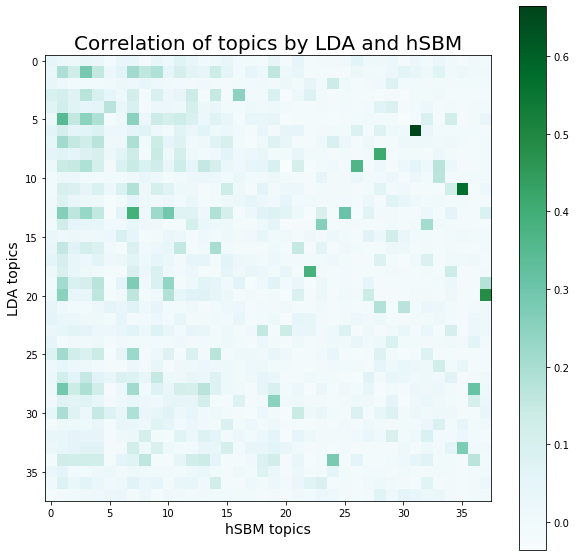

In [102]:
plt.figure(figsize=(10,10))

plt.imshow(topic_correlation_mtx, cmap='BuGn')
plt.colorbar()

plt.title('Correlation of topics by LDA and hSBM', fontsize=20)
plt.xlabel('hSBM topics', fontsize=14)
plt.ylabel('LDA topics', fontsize=14)

#plt.savefig('../img/correlation_l1.png')
plt.show()

In [103]:
print('Highest correlation topics:')
print(f'\tLDA:  {np.argmax(topic_correlation_mtx) // topic_correlation_mtx.shape[1]}')
print(f'\thSBM: {np.argmax(topic_correlation_mtx) % topic_correlation_mtx.shape[1]}')

6 31


In [111]:
lda_topics[20]

{'follow': 0.03446170568560532,
 'twitter': 0.015944711312874633,
 'book': 0.015291933373050928,
 'patriot': 0.01420789535408689,
 'comment': 0.01330796303795448,
 'read': 0.01220999709036848,
 'night': 0.011912812998403256,
 'maga': 0.011890966034203053,
 'part': 0.01173085865064463,
 'tweet': 0.011083447922632918,
 'write': 0.010409881932339746,
 'retweet': 0.010020468037675648,
 'back': 0.009057774826731771,
 'togeth': 0.009008322531051554,
 'genius': 0.008790481531765672,
 'saw': 0.008698409122576467,
 'smart': 0.008606826589044578,
 'blue': 0.00850161694407193,
 'get': 0.008371402220157715,
 'perhap': 0.008077318500936223,
 'red': 0.007950280518214222,
 'block': 0.007800408369397046,
 'one': 0.007605336343628367,
 'pick': 0.007463799065904623,
 'hear': 0.007422401778893839,
 'think': 0.007386178919928767,
 'leav': 0.007111157510505627,
 'fee': 0.007053004799634078,
 'know': 0.0070080116762869914,
 'believ': 0.006977929026844127,
 'delusion': 0.006856951625566953,
 'say': 0.0067965

In [112]:
hsbm_topics[37]

{'follow': 0.2505938242280285,
 'tweet': 0.14489311163895488,
 'retweet': 0.06175771971496437,
 'block': 0.05344418052256532,
 'comment': 0.04334916864608076,
 'list': 0.042161520190023755,
 'share': 0.040380047505938245,
 'train': 0.03800475059382423,
 'night': 0.03681710213776722,
 'awesom': 0.029691211401425176,
 'troll': 0.029691211401425176,
 'appreci': 0.021971496437054632,
 'bot': 0.020190023752969122,
 'thread': 0.01840855106888361,
 'profil': 0.0166270783847981,
 'often': 0.016033254156769598,
 'tomorrow': 0.015439429928741092,
 'repli': 0.014251781472684086,
 'ifb': 0.011876484560570071,
 'asap': 0.011282660332541567,
 'load': 0.00831353919239905,
 'unfollow': 0.00831353919239905,
 'content': 0.00831353919239905,
 'jack': 0.00831353919239905,
 'aboard': 0.007125890736342043,
 'bio': 0.006532066508313539,
 'purchas': 0.006532066508313539,
 'acct': 0.0059382422802850355,
 'juli': 0.005344418052256532,
 'twit': 0.004750593824228029,
 'solid': 0.004156769596199525,
 'toni': 0.002